In [ ]:
                ## Part 1: AE and VAE
## 1. Establish an auto-encoder Architecture

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Sigmoid activation to ensure output in [0,1] range
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
## 2. Establish an Variational auto-encoder Architecture


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define the Variational Autoencoder (VAE) architecture
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 146998423.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 52530656.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49602594.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5879792.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



-----AutoEncoder-----
Epoch 1/10, Total Loss: 0.9490205237606187
Epoch 2/10, Total Loss: 0.9253694263856802
Epoch 3/10, Total Loss: 0.9253696029120163
Epoch 4/10, Total Loss: 0.9253676904798317
Epoch 5/10, Total Loss: 0.9253698487017454
Epoch 6/10, Total Loss: 0.9253662365840188
Epoch 7/10, Total Loss: 0.9253674595594914
Epoch 8/10, Total Loss: 0.9253678873403749
Epoch 9/10, Total Loss: 0.9253672562174197
Epoch 10/10, Total Loss: 0.925369349115693
-----VariationAutoEncoder-----
Epoch 1/10, Total Loss: 2.147980965276771
Epoch 2/10, Total Loss: 0.9269045021996569
Epoch 3/10, Total Loss: 0.9259007991249881
Epoch 4/10, Total Loss: 0.9256209370169812
Epoch 5/10, Total Loss: 0.9255064447551394
Epoch 6/10, Total Loss: 0.9254501125197421
Epoch 7/10, Total Loss: 0.9254225930933759
Epoch 8/10, Total Loss: 0.9254033161378873
Epoch 9/10, Total Loss: 0.9254114632921686
Epoch 10/10, Total Loss: 0.9253936700983596


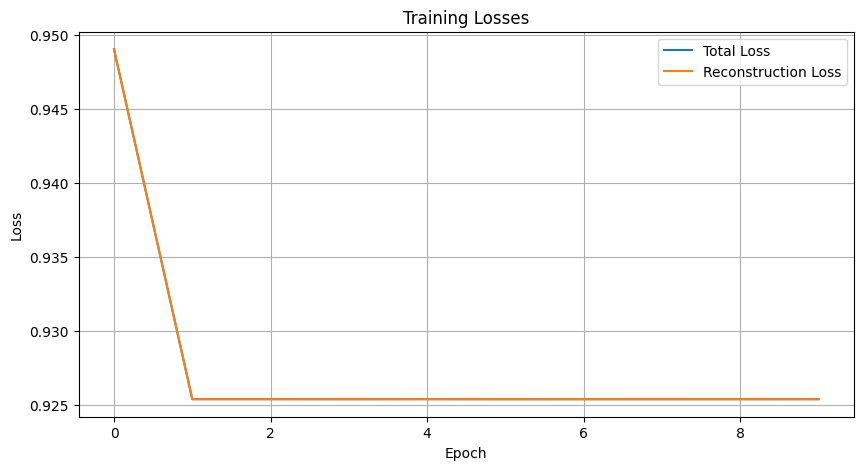

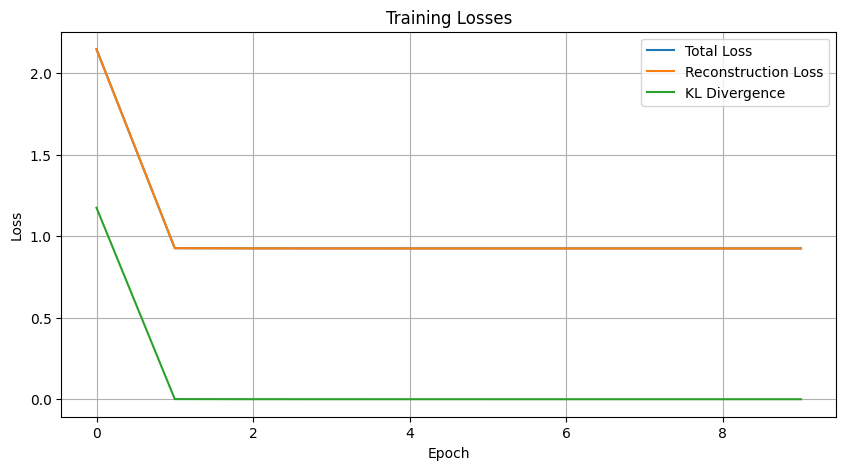

In [ ]:
## 3. Evaluate the two models by plotting (Loss, KL divergence, etc), what you conclude.

import matplotlib.pyplot as plt

# Function to train the models
def train(model, train_loader, criterion, optimizer, num_epochs):
    total_losses = []
    recon_losses = []
    kld_losses = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        recon_loss = 0.0
        kld_loss = 0.0

        for data in train_loader:
            inputs, _ = data
            optimizer.zero_grad()
            if isinstance(model, VAE):
                recon_batch, mu, logvar = model(inputs)
                BCE = criterion(recon_batch, inputs.view(-1, 784))
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = BCE + KLD
                kld_loss += KLD.item()
            else:
                outputs = model(inputs.view(inputs.size(0), -1))
                loss = criterion(outputs, inputs.view(inputs.size(0), -1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            recon_loss += loss.item()

        total_losses.append(total_loss / len(train_loader))
        recon_losses.append(recon_loss / len(train_loader))
        if isinstance(model, VAE):
            kld_losses.append(kld_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss/len(train_loader)}")

    return total_losses, recon_losses, kld_losses

# Define function to plot losses
def plot_losses(total_losses, recon_losses, kld_losses=None):
    plt.figure(figsize=(10, 5))
    plt.plot(total_losses, label='Total Loss')
    plt.plot(recon_losses, label='Reconstruction Loss')
    if kld_losses:
        plt.plot(kld_losses, label='KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
criterion = torch.nn.MSELoss()
# Train AE
ae_model = Autoencoder()
ae_optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
print("-----AutoEncoder-----")
ae_total_losses, ae_recon_losses, _ = train(ae_model, train_loader, criterion, ae_optimizer, num_epochs=10)

# Train VAE
vae_model = VAE()
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
print("-----VariationAutoEncoder-----")
vae_total_losses, vae_recon_losses, vae_kld_losses = train(vae_model, train_loader, criterion, vae_optimizer, num_epochs=10)

# Plot losses
plot_losses(ae_total_losses, ae_recon_losses)
plot_losses(vae_total_losses, vae_recon_losses, vae_kld_losses)

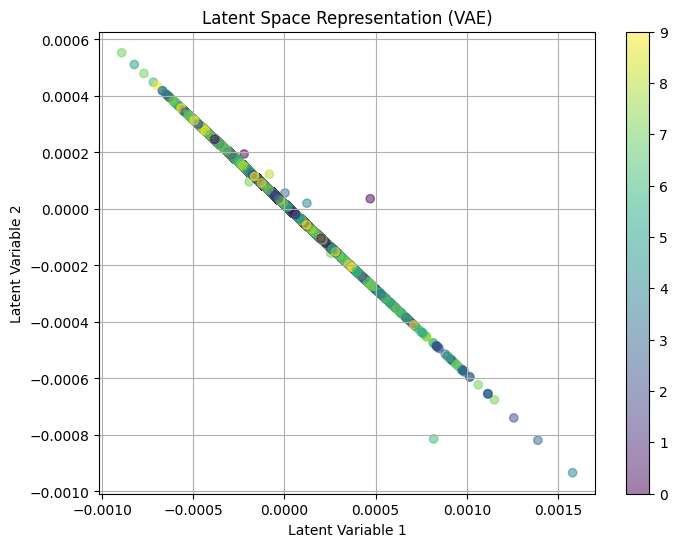

In [ ]:
## 4. Try to plot the latent space of the two models

import numpy as np

# Function to generate latent space representations
def generate_latent_space(model, data_loader):
    latent_space = []
    labels = []

    for data in data_loader:
        inputs, target = data
        mu, _ = model.encode(inputs.view(-1, 784))
        latent_space.append(mu.detach().numpy())
        labels.append(target.numpy())

    latent_space = np.concatenate(latent_space, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_space, labels

# Generate latent space representations for VAE
vae_latent_space, vae_labels = generate_latent_space(vae_model, train_loader)

# Plot latent space
plt.figure(figsize=(8, 6))
plt.scatter(vae_latent_space[:, 0], vae_latent_space[:, 1], c=vae_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space Representation (VAE)')
plt.grid(True)
plt.show()

In [ ]:
!pip install kaggle

In [ ]:
## Part 1: GANs

## 1. Using Pytorch Library Define Generator

from kaggle.api.kaggle_api_extended import KaggleApi
g_losses = []
d_losses = []
# Initialize the Kaggle API
api = KaggleApi()
# If you haven't set your Kaggle API key, you can set it here:
# api.authenticate()

# Download the dataset
dataset_name = 'bryanb/abstract-art-gallery'
api.dataset_download_files(dataset_name, path='./abstract_art_gallery', unzip=True)

print("Dataset downloaded successfully.")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape[0] * img_shape[1] * img_shape[2]),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape[0] * img_shape[1] * img_shape[2], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Define Loss Function
adversarial_loss = nn.BCELoss()

# Initialize Generator and Discriminator
latent_dim = 100
img_shape = (3, 64, 64)  # Change the shape according to your dataset
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# GPU Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Configure Data Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root='./abstract_art_gallery', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        print(
            f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )

Dataset downloaded successfully.
[Epoch 0/50] [Batch 0/45] [D loss: 0.698462724685669] [G loss: 0.6694331765174866]
[Epoch 0/50] [Batch 1/45] [D loss: 0.5538437366485596] [G loss: 0.816421627998352]
[Epoch 0/50] [Batch 2/45] [D loss: 0.38812124729156494] [G loss: 1.0088940858840942]
[Epoch 0/50] [Batch 3/45] [D loss: 0.2934413254261017] [G loss: 1.2447786331176758]
[Epoch 0/50] [Batch 4/45] [D loss: 0.23655831813812256] [G loss: 1.4480345249176025]
[Epoch 0/50] [Batch 5/45] [D loss: 0.17778269946575165] [G loss: 1.5550669431686401]
[Epoch 0/50] [Batch 6/45] [D loss: 0.18765601515769958] [G loss: 1.5129587650299072]
[Epoch 0/50] [Batch 7/45] [D loss: 0.1944645643234253] [G loss: 1.354235053062439]
[Epoch 0/50] [Batch 8/45] [D loss: 0.22101713716983795] [G loss: 1.197076439857483]
[Epoch 0/50] [Batch 9/45] [D loss: 0.2516433298587799] [G loss: 1.100975751876831]
[Epoch 0/50] [Batch 10/45] [D loss: 0.25050944089889526] [G loss: 1.0657882690429688]
[Epoch 0/50] [Batch 11/45] [D loss: 0.257

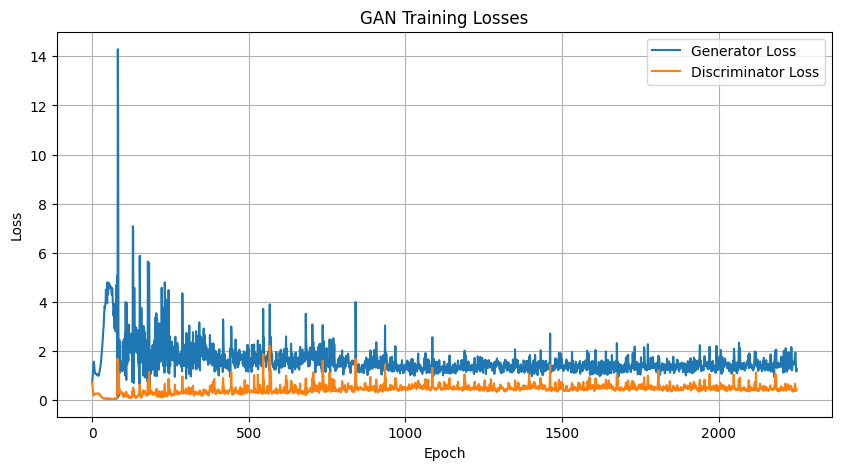

In [ ]:
## 2. Evaluate the model by plotting (Loss, KL divergence, etc) (Generator and Discriminator), what you conclude

import matplotlib.pyplot as plt

def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming g_losses and d_losses are lists containing the generator and discriminator losses for each epoch
plot_losses(g_losses, d_losses)


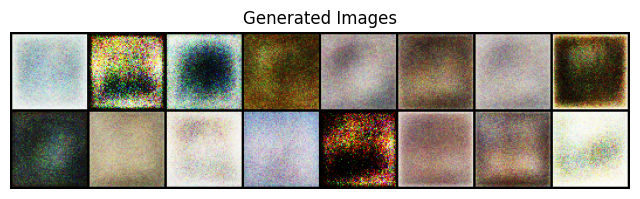

In [ ]:
## 3. Generate the new Data
import torchvision.utils as vutils

# Generate new data
num_samples = 16
z = torch.randn(num_samples, latent_dim, device=device)
with torch.no_grad():
    fake_images = generator(z).detach().cpu()

# Plot the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
